In [93]:
import os
import json
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, clip_processor, clip_model, label_binarizer, max_length=77, is_training=True, is_labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.clip_processor = clip_processor
        self.clip_model = clip_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  # New attribute to indicate training mode
        self.is_labeled = is_labeled  # New flag to indicate if data is labeled

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]

        if self.is_labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids 
        

    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]

        if labeled and self.label_binarizer:
            labels = [sample.get("labels", []) for sample in batch]
            default_label = ['None']
            labels = [label if label else default_label for label in labels]
            y = self.label_binarizer.transform(labels)
        else:
            y = None

        processed_texts = self.clip_processor(text=[text[:self.max_length] for text in texts], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.clip_model.device) for k, v in processed_texts.items()}
        text_embeddings = self.clip_model.get_text_features(**inputs).cpu().detach().numpy()

        if labeled:
            return text_embeddings, y
        else:
            return text_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class MemeClassification:
    def __init__(self, label_tree):
        self.label_tree = label_tree
        self.label_binarizer = MultiLabelBinarizer()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = None
        self.file_paths = {
            'train': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask1/merged_file.json',
            'dev': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels/dev_subtask1_en.json',
            'test': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/english/en_subtask1_test_unlabeled.json'
        }

    def load_and_preprocess_data(self, data_type, sample_size=None):
        # Select the file path based on the data_type
        json_file_path = self.file_paths.get(data_type)
        if not json_file_path:
            raise ValueError(f"Invalid data type: {data_type}")

        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        # Handling labels differently based on data_type
        if data_type == 'test':
            # For 'test' data, labels may not be present
            labels = [sample.get("labels", None) for sample in data]
            # Keep only samples with labels (filter out None)
            labels = [label for label in labels if label is not None]
        else:
            # For 'train' and 'dev' data, assign a default label if none exist
            default_label = ['None']
            labels = [sample.get("labels", []) for sample in data]
            labels = [label if label else default_label for label in labels]

        self.label_binarizer.fit(labels)

        return data
    
    def explore_data(self, data_type='train', sample_size=None, examples_to_show=2):
        # Load data
        data = self.load_and_preprocess_data(data_type, sample_size)
        print(f"Total number of samples: {len(data)}")

        # Unique labels
        unique_labels = self.label_binarizer.classes_
        print(f"Total number of unique labels: {len(unique_labels)}")
        print("Unique labels:", unique_labels)

        # Initialize a DataGenerator with a small batch of data
        small_batch_data = data[:examples_to_show]
        data_generator = DataGenerator(small_batch_data, len(small_batch_data), self.clip_processor, self.clip_model, self.label_binarizer)

        # Processed data examples
        for i, sample in enumerate(small_batch_data):
            print(f"\nSample {i+1}:")
            print("Original Text:", sample["text"])
            processed_text, _ = data_generator.preprocess_data([sample])
            print("Processed Text:", processed_text)         

    def build_model(self, num_classes=21, clip_embedding_size=512, dropout_rate=0.5, learning_rate=0.005):
        input_embedding_input = Input(shape=(clip_embedding_size,), dtype='float32', name="input_embedding")
        dense_layer = Dense(512, activation='relu')(input_embedding_input)
        dropout_layer = Dropout(dropout_rate)(dense_layer)

        output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)

        self.model = Model(inputs=input_embedding_input, outputs=output_layer)
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    def train_model(self, save_model_path, batch_size=64, data_type='train', epochs=5, validation_size=0.2, learning_rate=0.005, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        # Split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        # Generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        # Initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=True)
        val_generator = DataGenerator(val_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=True)

        #build  the model
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.5, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

        #train the model
        history = self.model.fit(
            train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping]
        )

        # Save model
        self.model.save_weights(save_model_path)
        print(f"Model saved at {save_model_path}")

        return history
   
    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      

    def calculate_hierarchy_distance(self, node1, node2):
        # Convert node1 and node2 to tuples
        node1_tuple = tuple(node1)
        node2_tuple = tuple(node2)

        # Check if the nodes are leaf nodes
        if node1_tuple not in self.label_tree or node2_tuple not in self.label_tree:
            return None

        # Find ancestors of each leaf node
        ancestors1 = set()
        current_node = node1_tuple
        while current_node:
            ancestors1.add(current_node)
            current_node = next((parent for parent, children in self.label_tree.items() if current_node in children), None)

        ancestors2 = set()
        current_node = node2_tuple
        while current_node:
            ancestors2.add(current_node)
            current_node = next((parent for parent, children in self.label_tree.items() if current_node in children), None)

        # Find common ancestors
        common_ancestors = ancestors1.intersection(ancestors2)

        # Distance based on levels
        distance = len(ancestors1) + len(ancestors2) - 2 * len(common_ancestors)

        return distance

    def evaluate_model(self, batch_size, save_model_path, num_classes, output_json_path, data_type='dev', learning_rate=0.005):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)

        # Initialize data generator for the test data in evaluation mode
        test_generator = DataGenerator(dev_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=False)

        # Build the model and load saved weights
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.5, learning_rate=learning_rate)
        self.model.load_weights(save_model_path)

        # Initialize variables for metrics calculation
        total_precision = 0
        total_recall = 0
        total_samples = 0
        true_labels_all = []
        predicted_labels_all = []

        # Initialize MultiLabelBinarizer
        mlb = MultiLabelBinarizer(classes=self.label_binarizer.classes_)
        mlb.fit([self.label_binarizer.classes_])

        results = []  # List to store results

        # Iterate over batches in the test generator
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            # Iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if true_label[j] == 1]
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.5]
                prediction_list = prediction.tolist()

                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}

                true_labels_all.append(gold_labels)
                predicted_labels_all.append(predicted_labels)

                results.append({
                    'id': sample_id,
                    'ture_labels': gold_labels,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities  # Convert numpy array to list
                    
                })
                
                # Hierarchical evaluation
                for predicted_label in predicted_labels:
                    if predicted_label in gold_labels:
                        total_precision += 1
                        total_recall += 1
                    else:
                        for gold_label in gold_labels:
                            distance = self.calculate_hierarchy_distance(predicted_label, gold_label)
                            if distance is not None and distance > 0:
                                total_precision += 0.5
                                total_recall += 0.5

                total_samples += 1

        # Aggregate metrics over all samples
        average_precision = total_precision / total_samples if total_samples > 0 else 0
        average_recall = total_recall / total_samples if total_samples > 0 else 0
        hierarchical_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) != 0 else 0

        true_labels_all_binary = mlb.transform(true_labels_all)
        predicted_labels_all_binary = mlb.transform(predicted_labels_all)

        target_names = self.label_binarizer.classes_


        # Print classification report
        print("Classification Report:")
        print(classification_report(true_labels_all_binary, predicted_labels_all_binary, target_names=target_names))
        
        result_file_name = f"subtask1_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)

        return hierarchical_f1

    def test_model(self, batch_size, save_model_path, output_json_path, data_type='test', learning_rate=0.001):
        test_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(test_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=False, is_labeled=False)

        # Load the trained model weights
        self.build_model(num_classes=21, dropout_rate=0.5, learning_rate=learning_rate)
        self.model.load_weights(save_model_path)

        predictions = []

        # Iterate over batches in the test generator
        for X, batch_ids in test_generator:
            y_pred = self.model.predict(X)
            print("raw predictions:", y_pred) 
            # Iterate over predictions in the batch
            for sample_id, prediction in zip(batch_ids, y_pred):
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.5]
                prediction_list = prediction.tolist()

                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}
                
                predictions.append({
                    'id': sample_id,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities  # Convert numpy array to list
                    
                })         

        result_file_name = f"subtask1_test_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(predictions, json_file, indent=4)
            
        return "Predictions completed."


#hierarchical tree
#the assigned number are hypothetically
label_tree = {
    'Persuasion': {
        'Pathos': {
            'Appeal to Emotion(visual)': 1,
            'Exaggeration/Minimisation': 2,
            'Loaded Language': 3,
            'Flag waving': 4,
            'Appeal to fear/prejudice': 5,
            'Transfer': 6
        },
        'Ethos': {
            'Transfer': 6,
            'Glittering generalities': 7,
            'Appeal to authority': 8,
            'Bandwagon': 9,
            'Ad Hominem': {
                'Name calling/Labelling': 10,
                'Doubt': 11,
                'Smears': 12,
                'Reduction and Hitlerium': 13,
                'Whataboutism': 14
            }
        },
        'Logos': {
            'Repetition': 15,
            'Obfuscation, Intentional vagueness, Confusion': 16,
            'Justification': {
                'Flag waving': 4,
                'Appeal to fear/prejudice': 5,
                'Appeal to Authority': 8,
                'Bandwagon': 9,
                'Slogans': 17
            },
            'Reasoning': {
                'Distraction': {
                    'Whataboutism': 14,
                    'Presenting Irrelevant Data (Red Herring)': 18,
                    'Straw Man': 19
                },
                'Simplification': {
                    'Black-and-white Fallacy/Dictatorship': 20,
                    'Casual Oversimplification': 21,
                    'Thought-terminating cliché': 22
                }
            }
        },
        'None': 23 # a label for empty samples
    }
}
batch_size = 64
num_classes = 21
save_model_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask1/CLIP_model_weights'
output_json_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels'

CLIP_meme_classifier = MemeClassification(label_tree)


In [94]:
CLIP_meme_classifier.explore_data(data_type='train')


Total number of samples: 7000
Total number of unique labels: 21
Unique labels: ['Appeal to authority' 'Appeal to fear/prejudice' 'Bandwagon'
 'Black-and-white Fallacy/Dictatorship' 'Causal Oversimplification'
 'Doubt' 'Exaggeration/Minimisation' 'Flag-waving'
 'Glittering generalities (Virtue)' 'Loaded Language'
 "Misrepresentation of Someone's Position (Straw Man)"
 'Name calling/Labeling' 'None'
 'Obfuscation, Intentional vagueness, Confusion'
 'Presenting Irrelevant Data (Red Herring)' 'Reductio ad hitlerum'
 'Repetition' 'Slogans' 'Smears' 'Thought-terminating cliché'
 'Whataboutism']

Sample 1:
Original Text: THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ALL TIMES
Processed Text: [[-8.99127126e-02 -1.47744834e-01 -1.22467652e-01  3.35534811e-01
  -1.80598944e-01  2.76453227e-01 -1.34966709e-02 -1.32954597e+00
   4.23978269e-02 -2.48555839e-01 -4.94336709e-02 -2.88913846e-01
   3.44515175e-01 -4.00124609e-01 -6.16990365e-02  2.60938331e-02
   2.08111852e-01 -3.20450783e-01  3.32062

In [95]:
history= CLIP_meme_classifier.train_model(save_model_path, 
                                          batch_size=64,
                                          learning_rate=0.0005,
                                          epochs=15,
                                          data_type='train'
                                         )


Epoch 1/15
88/88 [==============================] - 46s 525ms/step - loss: 0.2919 - accuracy: 0.1796 - val_loss: 0.2360 - val_accuracy: 0.2643
Epoch 2/15
88/88 [==============================] - 45s 512ms/step - loss: 0.2229 - accuracy: 0.3191 - val_loss: 0.2233 - val_accuracy: 0.3121
Epoch 3/15
88/88 [==============================] - 45s 511ms/step - loss: 0.2090 - accuracy: 0.3530 - val_loss: 0.2176 - val_accuracy: 0.2964
Epoch 4/15
88/88 [==============================] - 46s 520ms/step - loss: 0.2005 - accuracy: 0.3725 - val_loss: 0.2166 - val_accuracy: 0.3243
Epoch 5/15
88/88 [==============================] - 46s 523ms/step - loss: 0.1932 - accuracy: 0.3925 - val_loss: 0.2146 - val_accuracy: 0.3279
Epoch 6/15
88/88 [==============================] - 45s 512ms/step - loss: 0.1868 - accuracy: 0.4116 - val_loss: 0.2141 - val_accuracy: 0.3336
Epoch 7/15
88/88 [==============================] - 45s 514ms/step - loss: 0.1809 - accuracy: 0.4250 - val_loss: 0.2140 - val_accuracy: 0.3257

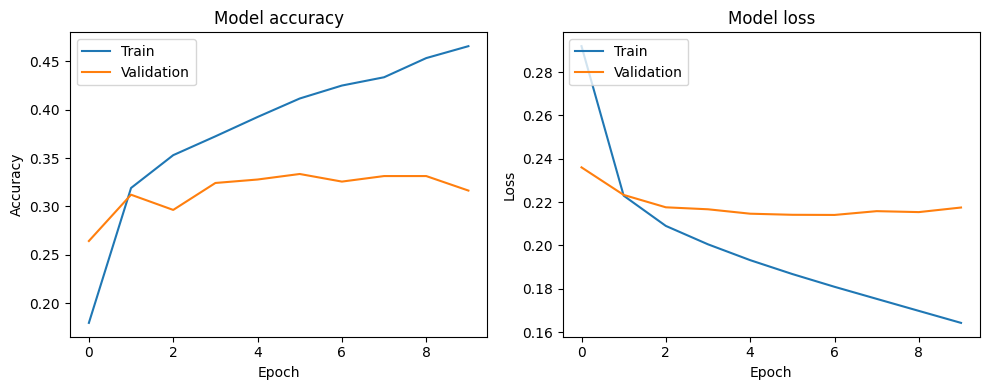

In [96]:
#plot the training history
CLIP_meme_classifier.plot_training_history(history)

In [97]:
#evaluate the model using the dev data
hierarchical_f1 = CLIP_meme_classifier.evaluate_model(batch_size, 
                                                      save_model_path, 
                                                      num_classes, 
                                                      output_json_path, 
                                                      data_type='dev'
                                                     )
print(f"Average Hierarchical F1: {hierarchical_f1}")


2/2 [==============================] - 0s 1ms/step
Classification Report:
                                                     precision    recall  f1-score   support

                                Appeal to authority       0.70      0.54      0.61       136
                           Appeal to fear/prejudice       0.20      0.02      0.03        66
                                          Bandwagon       0.00      0.00      0.00        16
               Black-and-white Fallacy/Dictatorship       0.38      0.03      0.06        98
                          Causal Oversimplification       0.00      0.00      0.00        53
                                              Doubt       0.00      0.00      0.00        45
                          Exaggeration/Minimisation       0.00      0.00      0.00        62
                                        Flag-waving       0.71      0.17      0.27        89
                   Glittering generalities (Virtue)       0.62      0.23      0.33      

/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
#prediction on the test data
CLIP_meme_classifier.test_model(batch_size, 
                                save_model_path, 
                                output_json_path,
                                data_type='test'
                               )


2/2 [==============================] - 0s 2ms/step
raw predictions: [[0.03929847 0.23441176 0.0009962  ... 0.17851667 0.07466103 0.02707854]
 [0.02074526 0.0372948  0.01177212 ... 0.1844613  0.04217867 0.05486782]
 [0.99124646 0.1001486  0.00136968 ... 0.03701589 0.15650122 0.00733056]
 ...
 [0.00470476 0.02458629 0.00691508 ... 0.04887969 0.01157334 0.01230959]
 [0.24303295 0.12441945 0.00542169 ... 0.1224124  0.06121682 0.03928403]
 [0.00478509 0.0216991  0.00172798 ... 0.28925687 0.01705412 0.00170156]]
2/2 [==============================] - 0s 3ms/step
raw predictions: [[0.63795096 0.06734902 0.00151184 ... 0.4479371  0.0562319  0.04151164]
 [0.02420856 0.0071423  0.00399845 ... 0.35784477 0.04422141 0.05308198]
 [0.00985299 0.0089712  0.00267376 ... 0.08438089 0.04313041 0.00177727]
 ...
 [0.21039012 0.01910756 0.00390722 ... 0.2922674  0.09890839 0.00626209]
 [0.00093808 0.01881717 0.02501954 ... 0.2841789  0.02293478 0.00844653]
 [0.03920493 0.02558151 0.0282157  ... 0.09093732 

'Predictions completed.'